In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
import seaborn as sn
import numpy as np
import joblib    
import pickle
from sklearn.metrics import confusion_matrix, classification_report

In [2]:
IMAGE_SIZE=256
BATCH_SIZE=32
CHANNELS=3
EPOCHS=35

In [3]:
dataset=tf.keras.preprocessing.image_dataset_from_directory(
    "D:\Ishita\IGDTUW (CSE)\Summer Internship 2023\Potato",
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 1500 files belonging to 3 classes.


In [4]:
class_names=dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [5]:
len(dataset)

47

(32, 256, 256, 3)
[2 2 0 1 1 0 1 1 2 0 1 2 1 0 0 2 0 2 0 2 0 1 0 0 0 2 2 2 0 2 1 2]


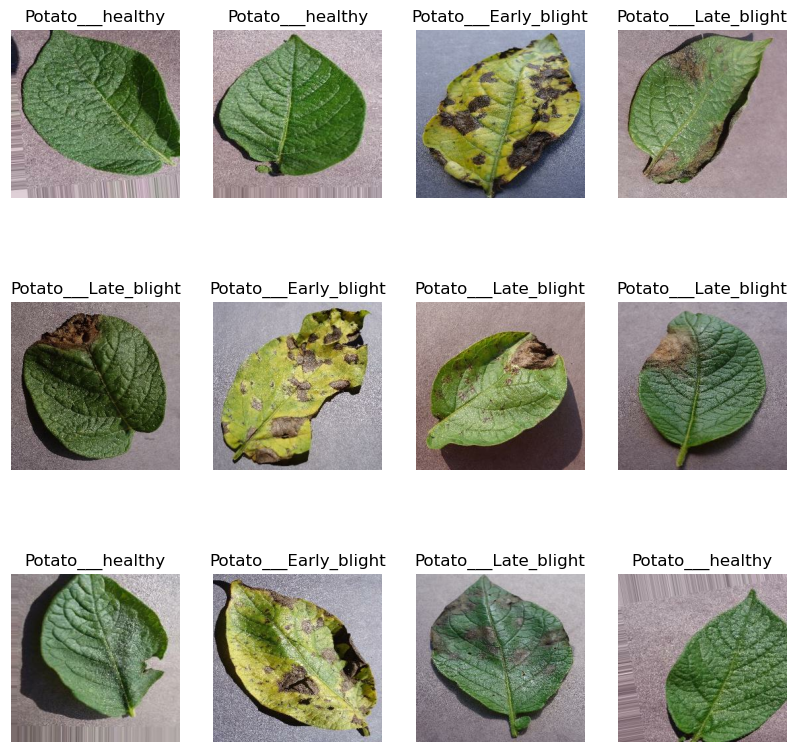

In [6]:
plt.figure(figsize=(10,10))
for image_batch, label_batch in dataset.take(1):
    print(image_batch.shape)
    print(label_batch.numpy())
    for i in range(12):
        ax=plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])
        plt.axis("off")

In [7]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    ds_size=len(ds)
    if shuffle:
        ds=ds.shuffle(shuffle_size, seed=12)
    train_size=int(train_split*ds_size)
    val_size=int(val_split*ds_size)
    train_ds=ds.take(train_size)
    val_ds=ds.skip(train_size).take(val_size)
    test_ds=ds.skip(train_size).skip(val_size)
    return train_ds, val_ds, test_ds
train_ds, val_ds, test_ds=get_dataset_partitions_tf(dataset)

In [8]:
print(len(train_ds), len(val_ds), len(test_ds))

37 4 6


In [9]:
train_ds=train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds=val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds=test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [10]:
resize_and_rescale=tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE,IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])
data_augmentation=tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2)
])

In [11]:
input_shape=(BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes=3
model=models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32, (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax')
])
model.build(input_shape=input_shape)
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 sequential_1 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (32, 127, 127, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (32, 62, 62, 64)         0         
 2D)                                                  

In [12]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)
history=model.fit(
    train_ds,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1,
    validation_data=val_ds
)

Epoch 1/35
37/37 [==============================] - 46s 1s/step - loss: 1.0656 - accuracy: 0.3669 - val_loss: 0.7785 - val_accuracy: 0.6484
Epoch 2/35
37/37 [==============================] - 45s 1s/step - loss: 0.6603 - accuracy: 0.6771 - val_loss: 0.4869 - val_accuracy: 0.7734
Epoch 3/35
37/37 [==============================] - 45s 1s/step - loss: 0.4450 - accuracy: 0.8042 - val_loss: 0.5177 - val_accuracy: 0.7734
Epoch 4/35
37/37 [==============================] - 45s 1s/step - loss: 0.3447 - accuracy: 0.8737 - val_loss: 0.4542 - val_accuracy: 0.7891
Epoch 5/35
37/37 [==============================] - 45s 1s/step - loss: 0.4598 - accuracy: 0.7992 - val_loss: 0.3767 - val_accuracy: 0.8203
Epoch 6/35
37/37 [==============================] - 45s 1s/step - loss: 0.3338 - accuracy: 0.8619 - val_loss: 0.3158 - val_accuracy: 0.8594
Epoch 7/35
37/37 [==============================] - 46s 1s/step - loss: 0.2781 - accuracy: 0.8949 - val_loss: 0.4086 - val_accuracy: 0.8125
Epoch 8/35
37/37 [==

In [13]:
scores=model.evaluate(test_ds)
scores

6/6 [==============================] - 2s 218ms/step - loss: 0.1189 - accuracy: 0.9531


[0.11888817697763443, 0.953125]

In [14]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [15]:
history.history['loss']

[1.0655598640441895,
 0.6603440046310425,
 0.4449956715106964,
 0.34466269612312317,
 0.4597870409488678,
 0.3337820768356323,
 0.27806907892227173,
 0.2782036066055298,
 0.23572659492492676,
 0.2190549373626709,
 0.19546836614608765,
 0.28389614820480347,
 0.19988574087619781,
 0.18684373795986176,
 0.18430231511592865,
 0.18675597012043,
 0.15772829949855804,
 0.1746780127286911,
 0.1434633433818817,
 0.11457619071006775,
 0.11870445311069489,
 0.15112844109535217,
 0.1030680313706398,
 0.11392517387866974,
 0.09736229479312897,
 0.055054280906915665,
 0.15742096304893494,
 0.06709626317024231,
 0.08841637521982193,
 0.053182221949100494,
 0.0868958905339241,
 0.0673518106341362,
 0.047216448932886124,
 0.051331304013729095,
 0.042784180492162704]

In [16]:
history.history['accuracy']

[0.3669491410255432,
 0.6771186590194702,
 0.8042373061180115,
 0.8737288117408752,
 0.7991525530815125,
 0.8618643879890442,
 0.8949152827262878,
 0.8881356120109558,
 0.9059321880340576,
 0.9194915294647217,
 0.9237288236618042,
 0.8881356120109558,
 0.9237288236618042,
 0.9228813648223877,
 0.9288135766983032,
 0.9330508708953857,
 0.941525399684906,
 0.9262712001800537,
 0.9423728585243225,
 0.949999988079071,
 0.9584745764732361,
 0.949999988079071,
 0.9635593295097351,
 0.9550847411155701,
 0.9618644118309021,
 0.9830508232116699,
 0.946610152721405,
 0.9771186709403992,
 0.9686440825462341,
 0.9805084466934204,
 0.9711864590644836,
 0.9720339179039001,
 0.9838982820510864,
 0.9805084466934204,
 0.9847457408905029]

In [17]:
history.history['val_loss']

[0.7784543633460999,
 0.4868702292442322,
 0.5176878571510315,
 0.4541819095611572,
 0.376659631729126,
 0.31575122475624084,
 0.4086344242095947,
 0.264660507440567,
 0.27966248989105225,
 0.2907242178916931,
 0.27336955070495605,
 0.30108702182769775,
 0.21844832599163055,
 0.2536054849624634,
 0.18975651264190674,
 0.22731716930866241,
 0.15610963106155396,
 0.29116103053092957,
 0.3132990598678589,
 0.3939542770385742,
 0.10140620917081833,
 0.2957838773727417,
 0.1430768072605133,
 0.11552268266677856,
 0.16418184340000153,
 0.3715208172798157,
 0.15984594821929932,
 0.20659908652305603,
 0.23287758231163025,
 0.15381938219070435,
 0.16143512725830078,
 0.10337832570075989,
 0.10055258870124817,
 0.17701458930969238,
 0.21551313996315002]

In [18]:
history.history['val_accuracy']

[0.6484375,
 0.7734375,
 0.7734375,
 0.7890625,
 0.8203125,
 0.859375,
 0.8125,
 0.875,
 0.8828125,
 0.8828125,
 0.8828125,
 0.859375,
 0.9140625,
 0.8828125,
 0.9140625,
 0.8671875,
 0.9375,
 0.8828125,
 0.890625,
 0.8359375,
 0.9765625,
 0.8828125,
 0.9453125,
 0.96875,
 0.9296875,
 0.875,
 0.921875,
 0.90625,
 0.90625,
 0.953125,
 0.9375,
 0.9765625,
 0.96875,
 0.9453125,
 0.9375]

In [19]:
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

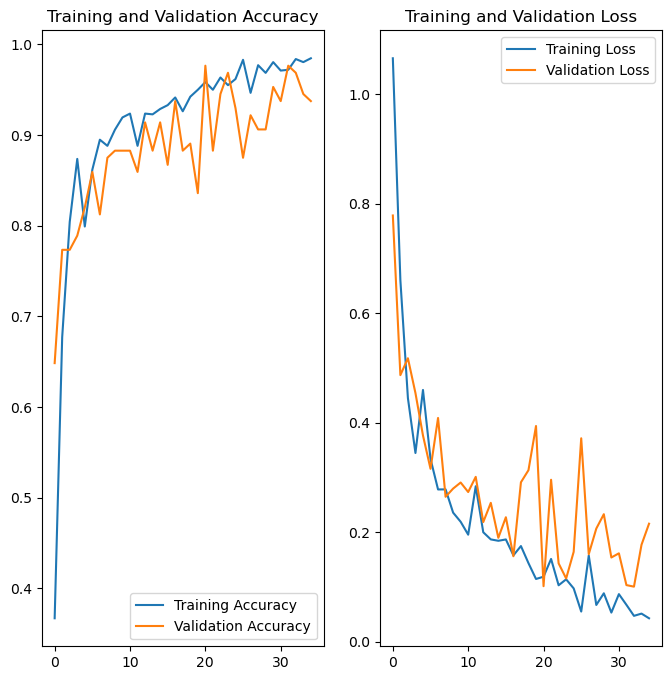

In [20]:
plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1,2,2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.show()

In [21]:
true_labels = []
pred_labels = []
for images_batch, labels_batch in test_ds.take(6):
    batch_prediction=model.predict(images_batch).argmax(axis=1)
    for i in labels_batch:
        true_labels.append(i)
    for i in batch_prediction:
        pred_labels.append(i)

1/1 [==============================] - 0s 264ms/step


In [22]:
def predict(model, img):
    img_array=tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array=tf.expand_dims(img_array,0)
    predictions=model.predict(img_array)
    predicted_class=class_names[np.argmax(predictions[0])]
    confidence=round(100*(np.max(predictions[0])),2)
    return predicted_class, confidence

1/1 [==============================] - 0s 41ms/step


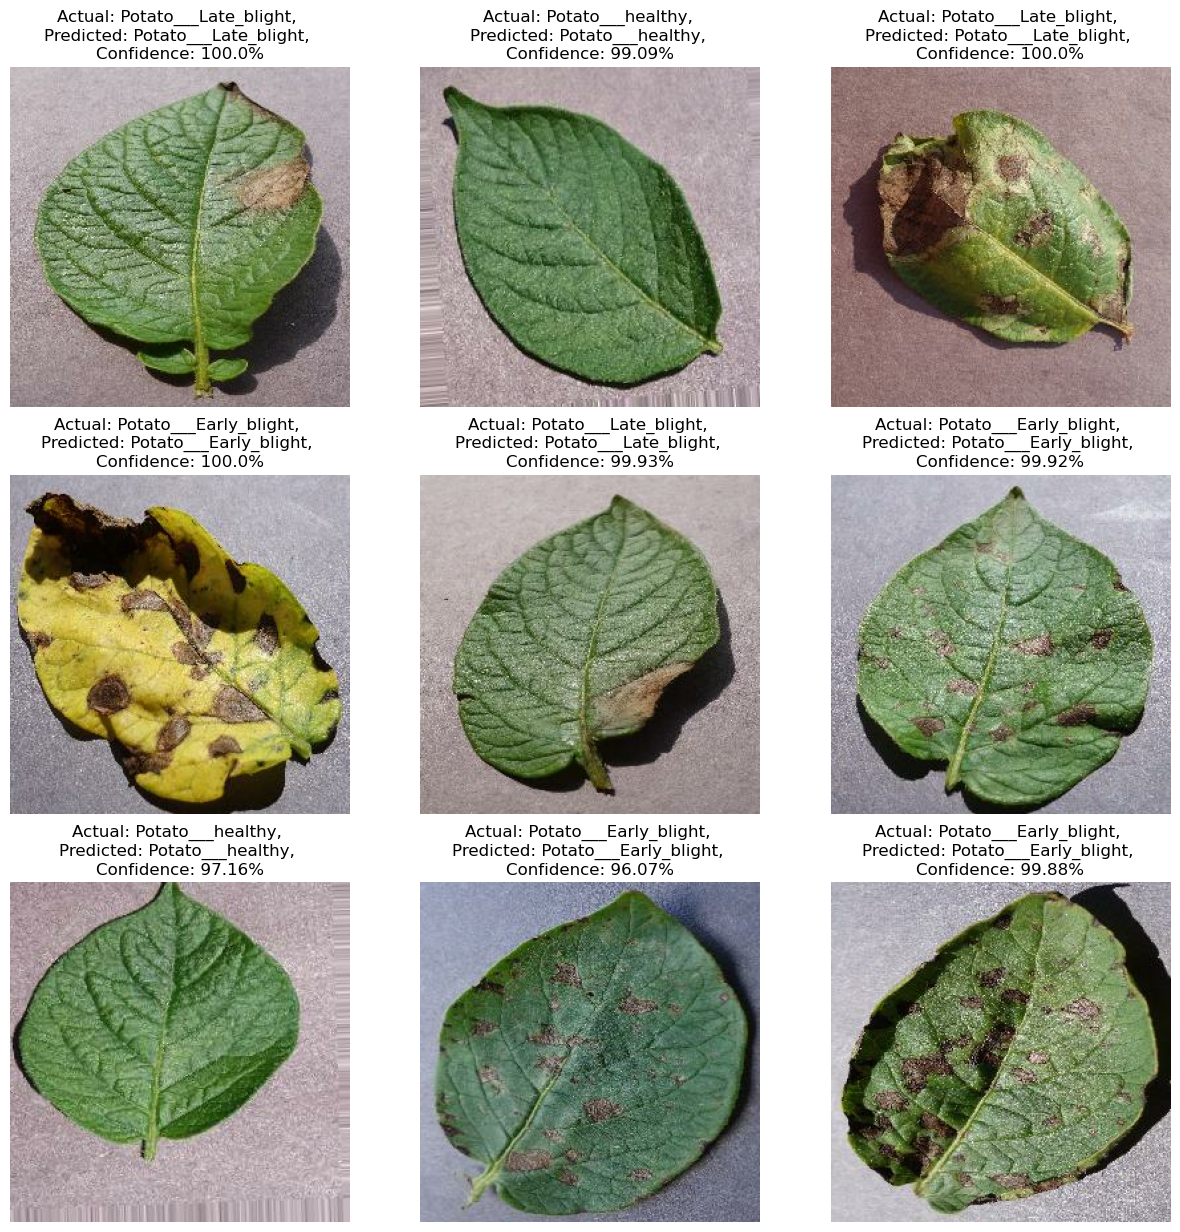

In [23]:
plt.figure(figsize=(15,15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax=plt.subplot(3,3,i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        predicted_class, confidence=predict(model,images[i].numpy())
        actual_class=class_names[labels[i]]
        plt.title(f"Actual: {actual_class}, \nPredicted: {predicted_class}, \nConfidence: {confidence}%")
        plt.axis("off")

In [24]:
print ("Classification Report: \n", classification_report(true_labels, pred_labels))

Classification Report: 
               precision    recall  f1-score   support

           0       0.90      1.00      0.95        72
           1       0.98      0.86      0.92        59
           2       1.00      0.98      0.99        61

    accuracy                           0.95       192
   macro avg       0.96      0.95      0.95       192
weighted avg       0.96      0.95      0.95       192



In [25]:
cm=tf.math.confusion_matrix(true_labels, pred_labels)
cm

<tf.Tensor: shape=(3, 3), dtype=int32, numpy=
array([[72,  0,  0],
       [ 8, 51,  0],
       [ 0,  1, 60]])>

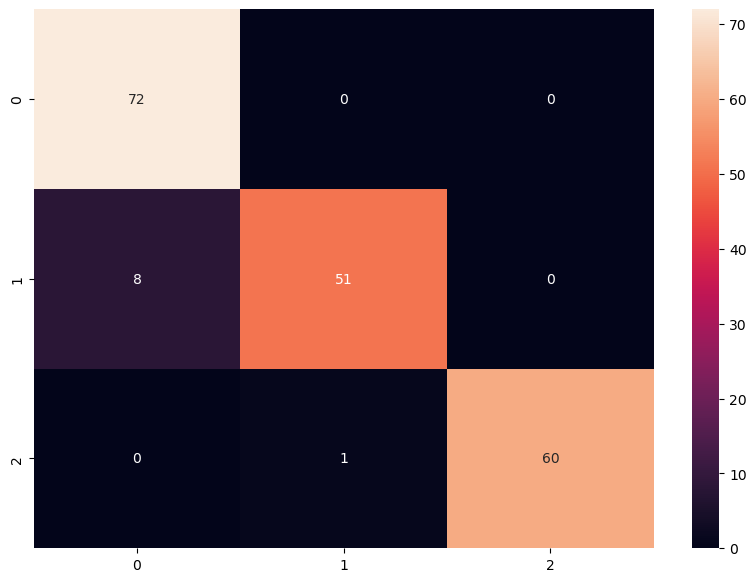

In [26]:
plt.figure(figsize=(10,7))
sn.heatmap(cm,annot=True,fmt='d')
plt.xlabel=('Predicted')
plt.ylabel=('Truth')

In [27]:
filename = "Model1-2-Epochs35.joblib"
joblib.dump(model, filename)

['Model1-2-Epochs35.joblib']